In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

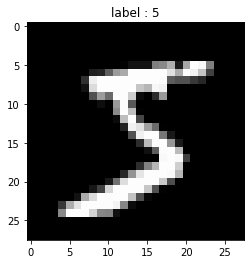

In [2]:
# MNISTデータをmodel入力用に整形
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
# 1次元にする
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 一つ可視化
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [3]:
# MNISTデータをmodel入力用に整形
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

print(X_train.shape)
print(X_test.shape)

# scaleを0 ~ 255から0 ~ 1にする
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# トレーニングとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# OHE作成
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000, 28, 28)
(10000, 28, 28)
(48000,)
(48000, 10)
float64


In [4]:
# ミニバッチ
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [5]:
# 結果確認、分析用の関数
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# scoreまとめ表示
def eval_accuracy(model, X_test, y_test, model_name):
    pred_y = model.predict(X_test)
    nn_result = pd.DataFrame(
        [accuracy_score(y_test, pred_y), precision_score(y_test, pred_y, average='micro'), recall_score(y_test, pred_y, average='micro')],
        index=['Accuracy', 'Precision', 'Recall'],
        columns=[model_name]
    )
    return nn_result

# 損失値の推移
def display_loss_graph(model):
    iter_list = list(range(len(model.loss_train)))
    plt.scatter(iter_list, model.loss_train, label="train loss")
    plt.scatter(iter_list, model.loss_val, label="test loss")
    plt.ylabel('loss')
    plt.xlabel('iter')
    plt.legend()
    plt.show()

In [6]:
class Sigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

In [7]:
layers = [ReLU(),ReLU(),Tanh(),Softmax()]

In [8]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.activation = activation

    def forward(self, X):
        self.X = X
        self.A = X@self.W + self.B
        return self.activation.forward(self.A)

    def backward(self, dZ):

        dA = self.activation.backward(dZ)
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        dZ = dA@self.W.T

        self.optimizer.update(self)

        return dZ

In [9]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
        
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

In [10]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB

In [11]:
class SimpleConv2d:
    # F: フィルタ数
    # FH: フィルター高さ
    # FW: フィルター幅
    # P: パディング数
    # S: ストライド数
    # C: チャンネル数
    def __init__(self, F, C, FH, FW, P, S, initializer=None, optimizer=None, activation=None):
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.W = self.initializer.W(F, C, FH, FW)
        self.B = self.initializer.B(F)
        
    def forward(self, X,debug=False):
        self.X = X
        # N: レコード数
        # C: チャネル数
        # H: 高さ
        # W: 幅
        # F: フィルター数
        N, C, H, W = self.X.shape
        F, C, FH, FW = self.W.shape
        OH, OW = self.output_shape2d(H, W, self.P, self.P, FH, FW, self.S, self.S)
        self.params = N, C, H, W, F, FH, FW, OH, OW
        A = np.zeros([N,F,OH,OW])
        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        A[n,ch,row,col] = np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]*self.W[ch,:,:,:]) +self.B[ch]
#         print("A: ", A.shape, A)
        if debug==True:
            return A
        else:
            return  self.activation.forward(A)

    def backward(self, dZ,debug=False):
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        N,C,H,W,F,FH,FW,OH,OW = self.params
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dZ = np.delete(dZ,dl_cols,axis=3)
        for n in range(N):
            for ch in range(F):
                for row in range(OH):
                    for col in range(OW):
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        self = self.optimizer.update(self)
        return dZ
    
    def output_shape2d(self, H, W, PH, PW, FH, FW, SH, SW):
        OH = (H + 2*PH - FH) / SH + 1
        OW = (W + 2*PW - FW) / SW + 1

        return int(OH), int(OW)

In [12]:
class SimpleInitializerConv2d:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, F, C, FH, FW):
        return self.sigma * np.random.randn(F, C, FH, FW)

    def B(self, F):
        return np.zeros(F)

In [13]:
x = np.array([[[[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12],[13, 14, 15, 16]]]])
w = np.array([[[[ 0.,  0.,  0.],[ 0.,  1.,  0.],[ 0., -1.,  0.]]],[[[ 0.,  0.,  0.],[ 0., -1.,  1.],[ 0.,  0.,  0.]]]])

In [14]:
simple_conv_2d = SimpleConv2d(F=2, C=1, FH=3, FW=3, P=0, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(0.01), activation=ReLU())
simple_conv_2d.W = w
A = simple_conv_2d.forward(x,True)
print(A)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [15]:
da = np.array([[[[ -4,  -4], [ 10,  11]],[[  1,  -7],[  1, -11]]]])
dZ = simple_conv_2d.backward(da,True)
print(dZ)

[[[[-5.  4.]
   [13. 27.]]]]


In [16]:
simple_conv_2d.output_shape2d(H=6,W=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1)

(4, 4)

In [17]:
class MaxPool2D():
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None

    def forward(self,A):
        N,F,OH,OW = A.shape
        PH,PW = int(OH/self.P),int(OW/self.P)
        self.params = N,F,OH,OW,self.P,PH,PW
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n,ch,row,col] = np.max(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
                        self.Pindex[n,ch,row,col] = np.argmax(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
        return self.PA
    
    def backward(self,dA):
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        for n in range(N): 
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        return dP

In [18]:
class Flatten:
    def __init__(self):
        pass
    def forward(self,X):
        self.shape = X.shape
        return X.reshape(len(X),-1)
    def backward(self,X):
        return X.reshape(self.shape)   

In [19]:
# argmaxはFlattenされた後のindex
np.argmax(np.array([[1,5], [3,4]]))

1

In [20]:
class Scratch2dCNNClassifier():
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
    
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))

    def accuracy(self,Z, Y):
        return accuracy_score(Y, Z)
    
    def fit(self, X, y, X_val=False, y_val=False):
        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:              
                forward_data = mini_X_train[:,np.newaxis,:,:]
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)

                Z = forward_data
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                backward_data = flt.backward(backward_data)
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)

                self.loss += self.loss_function(Z,mini_y_train)
                if self.verbose:
                    print('batch loss %f'%self.loss_function(Z,mini_y_train))
            if self.verbose:
                print(self.loss/len(get_mini_batch),self.accuracy(self.predict(X),np.argmax(y,axis=1)))
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        pred_data = X[:,np.newaxis,:,:]
        flt = Flatten()
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
        pred_data = flt.forward(pred_data)
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        return np.argmax(pred_data,axis=1)

In [21]:
NN = {
    0: FC(1960, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    1: FC(200, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    2: FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}
CNN = {
    0: SimpleConv2d(F=10, C=1, FH=3, FW=3, P=1, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(0.01),activation=ReLU()),
    1: MaxPool2D(2),
}

In [22]:
cnn2 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=1,n_batch=20,verbose=True)
cnn2.fit(X_train[:2000], y_train_one_hot[:2000])

batch loss 0.230400
batch loss 0.230453
batch loss 0.230169
batch loss 0.229982
batch loss 0.230353
batch loss 0.230628
batch loss 0.230767
batch loss 0.230394
batch loss 0.230900
batch loss 0.230146
batch loss 0.229920
batch loss 0.237231
batch loss 0.284944
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch loss nan
batch

In [33]:
y_pred = cnn2.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.097


CNNの代表的な構造


- LeNet

1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数


- AlexNet

- VGG16

#### フィルタサイズ

2次元畳み込み層において現在では3×3と1×1の使用が大半

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由

- 高さや幅方向を持たない1×1のフィルタの効果